## 3. Maximum Likelihood Estimators  
#### We analyze the Dow Jones Industrial Average from Stooq.

In [2]:
import pandas_datareader.data as web

import numpy as np

from scipy import stats 
from scipy.optimize import minimize 

from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter

In [3]:
data = web.DataReader ( '^DJI' , 'stooq' , start= '1995-01-01' , end='2023-11-14' )
data = data.reset_index()
dates = data [ "Date" ]
dow = data [ "Close" ].to_numpy()
data.head()

,Date,Open,High,Low,Close,Volume
0,2023-11-14,34581.20,34931.01,34581.20,34827.70,333309169.0
1,2023-11-13,34259.25,34405.84,34205.81,34337.87,248845725.0
2,2023-11-10,34020.82,34310.36,33905.62,34283.10,305324236.0
3,2023-11-09,34163.71,34167.54,33859.77,33891.94,333027530.0
4,2023-11-08,34185.92,34252.75,33996.20,34112.27,282794277.0


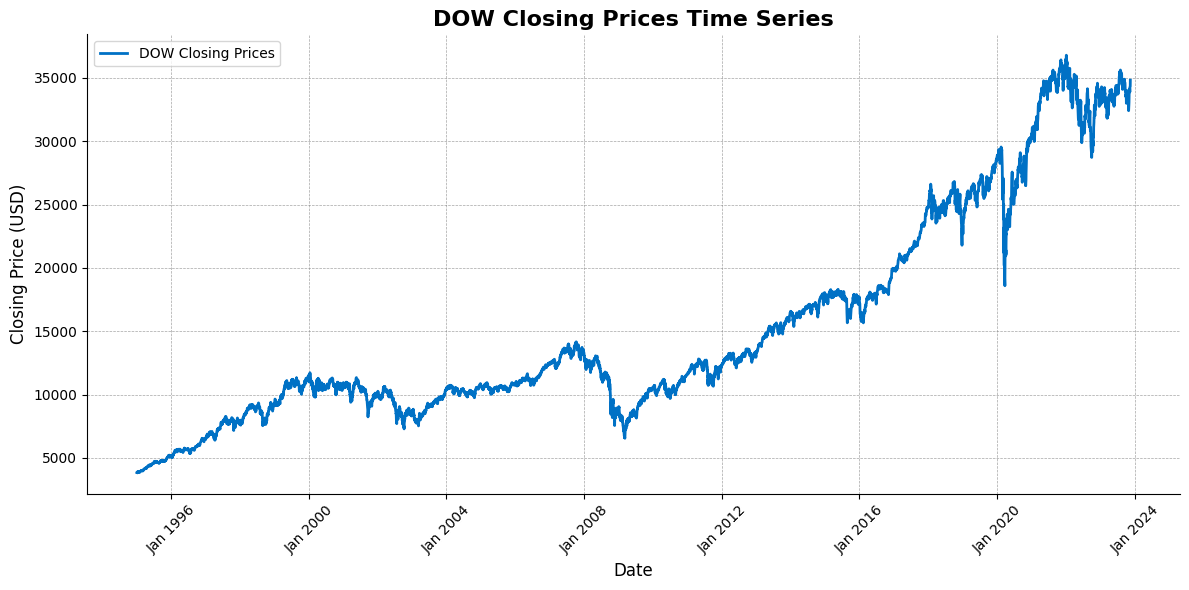

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
 
ax.plot(dates, dow, label="DOW Closing Prices", color="#0071C5", linewidth=2)

ax.xaxis.set_major_formatter( DateFormatter("%b %Y")  )
plt.xticks(rotation=45)
 
ax.grid(visible=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
ax.set_title("DOW Closing Prices Time Series", fontsize=16, weight="bold")
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Closing Price (USD)", fontsize=12)

ax.legend(loc="upper left", fontsize=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


#### We plot this time series and compute the time series of **(percentage) daily returns** using the formula:

$
\text{Return}_t = 100 \times \left( \frac{\text{Close}_t}{\text{Close}_{t-1}} - 1 \right).
$

 

In [5]:
data [ "perc_change_close" ] = (data [ "Close" ] / data [ "Close" ].shift(1) -1  )*100
data [ "perc_change_close" ].describe()

count    7268.000000
mean       -0.023723
std         1.152497
min       -10.205212
25%        -0.576726
50%        -0.055137
75%         0.459137
max        14.845566
Name: perc_change_close, dtype: float64

We then compute the sample **mean**, **variance**, **skewness**, and **kurtosis** of the daily returns. Based on this information, we will suggest which family of distributions might model these daily returns.

In [6]:
returns = data [ "perc_change_close" ].dropna().to_numpy()

mean = returns.mean()
variance = returns.var()
skewness = stats.skew(returns) 
kurtosis = stats.kurtosis(returns) 

print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis}")

Mean: -0.023722955410124806
Variance: 1.3280669272904766
Skewness: 0.6480631209171596
Kurtosis: 12.97781454831144


### Observations:

- **High kurtosis**:  
  Implies extreme outliers and fat tails. Hence, we would not consider the normal distribution, as it would model the majority of the data well but fail to represent/model well the extreme ends of the tails.

- **Skewness**:  
  The skewness isn't significantly high, indicating a reasonable level of symmetry.

 
We choose the **Student's t-distribution family** which captures the above characteristics effectively




###   ####
For this choice of family, we now estimate the parameter(s) which best explain the data using the **Maximum Likelihood Estimator** approach. To achieve this we:

- Implement the function which needs to be maximized. The parameter(s) which we are trying to estimate must of course be inputs to this function.
- Using the `minimize` function from `scipy.optimize`, we find the optimal parameters.

 (**Remark**: maximizing $ f(x) $ is the same thing as minimizing $ -f(x) $).   

In [7]:
def mle_function(params):
    degrees, mean, std = params
    
    #function to be maximised
    log_likelihood = np.sum(
                            np.log(
                                stats.t.pdf( returns, df= degrees, loc = mean, scale= std )
                            )
                        )
    
    return -log_likelihood     #return function to be minimised 
 
initial_guess = (4, 0 ,1 )
mle_output = minimize( mle_function, initial_guess, method='BFGS') 

mle_t_params = mle_output.x  
print(f"Optimal parameters using numerical approximation Broyden-Fletcher-Goldfarb-Shann (a quasi-Newton method type) are:")
print(f'{mle_t_params}')


Optimal parameters using numerical approximation Broyden-Fletcher-Goldfarb-Shann (a quasi-Newton method type) are:
[ 2.85349194 -0.06273681  0.68881401]


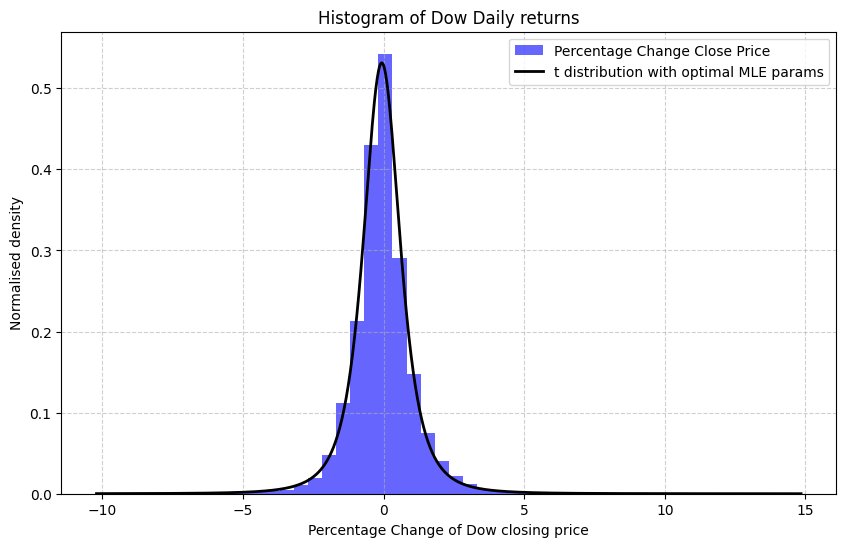

In [8]:
#fitting the t distribution based on optimal parameters optained via MLE to the data
degrees, mu, std = params =  mle_t_params

x = np.linspace(min(returns), max(returns), 1000 )  
p = stats.t.pdf(x,   df= degrees, loc = mu, scale= std )  

plt.figure(figsize=(10, 6))

plt.hist(returns, bins=50, color='blue', alpha=0.6, density=True, label="Percentage Change Close Price")
plt.plot(x, p, 'k-', linewidth=2, label= "t distribution with optimal MLE params")
plt.title("Histogram of Dow Daily returns")
plt.xlabel("Percentage Change of Dow closing price")
plt.ylabel("Normalised density")

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Disclaimer:**  
We could use a rounded form of the degrees of freedom (df) optimal parameter value obtained by Maximum Likelihood Estimation (MLE), as mathematically the degrees of freedom are defined as non-negative integers. However, since `SciPy` is capable of handling non-integer `df` values (for computational purposes, leveraging interpolated methods), we leave the parameter as is.
Otherwise, we would use `df=3`, which yields similar results.



We check the results obtained in the previous step by comparing it with the parameters you obtain from `scipy`'s `fit` function. Again, plot the PDF of the distribution with these parameters against a histogram of the daily returns.


In [9]:
print(f"MLE t-dist Params: {mle_t_params}")
print(f"SciPy Fit Params: {np.array(stats.t.fit(returns))}")

MLE t-dist Params: [ 2.85349194 -0.06273681  0.68881401]
SciPy Fit Params: [ 2.85349593 -0.06274108  0.6888111 ]


In [10]:
if np.allclose(mle_t_params , stats.t.fit(returns), atol = 1e-5  ):
    print('The results we obtained in the previous step compared with the parameters `scipy`s `fit` function provides are identical (4 d.p.).\n'
          'This makes sense as both methods use Maximum Likelihood method to calculate the optimal parameters.'
    )
else:
    print('The results we obtained in the previous step differ from the parameters provided by `scipy`\'s `fit` function.\n'
        'This may be due to precision differences occured due to different numerical approximation methods or slight variations in implementation details.'
    )

The results we obtained in the previous step compared with the parameters `scipy`s `fit` function provides are identical (4 d.p.).
This makes sense as both methods use Maximum Likelihood method to calculate the optimal parameters.


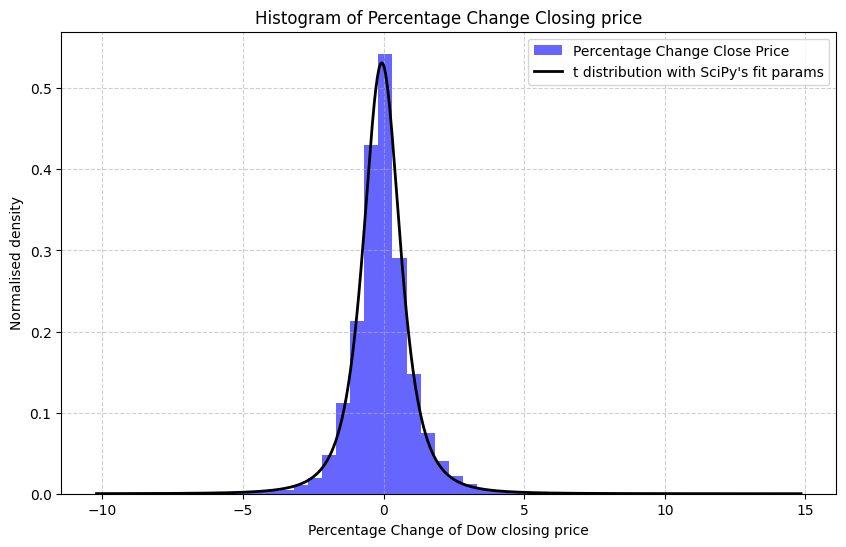

In [11]:
#fitting the t distribution based on optimal parameters optained via `scipy`s `fit` function
degrees, mu, std = params =  stats.t.fit(returns)

x = np.linspace( min(returns), max(returns), 1000 )   
p = stats.t.pdf(x,   df= degrees, loc = mu, scale= std )  

plt.figure(figsize=(10, 6))

plt.hist(returns, bins=50, color='blue', alpha=0.6, density=True, label="Percentage Change Close Price")
plt.plot(x, p, 'k-', linewidth=2, label= "t distribution with SciPy's fit params")

plt.title("Histogram of Percentage Change Closing price")
plt.xlabel("Percentage Change of Dow closing price")
plt.ylabel("Normalised density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()